<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/copy_of_copy_Alpha_RNNs_regime_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive')

In [0]:
def heaviside(x):
    if x>=0:
        return 1
    else:
        return 0

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from alphaRNN import *
from keras.layers import Layer
from keras import backend as K
from keras import layers
import keras.layers
#from alphaRNN import *
from keras import *
from keras.legacy import interfaces

	
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
# To make this notebook's output stable across runs
#def reset_graph(seed=42):
#    tf.reset_default_graph()
#    tf.set_random_seed(seed)
#    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, eps=0.01):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    step_length=np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      mu[i*step_length:((i*step_length)+1)]=step_size*(-1)**i
     
    for i in range(1, length):
        sigma[i]=sigma[i-1] + mu[i] + eps*np.random.normal(0,1)
        
    return sigma   


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
p = 30 # the number of lags (in both the data and the models)
vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

In [0]:
df = pd.DataFrame(vols, columns=['vol'])

In [9]:
use_features = ['vol'] 
target = 'vol'
n_steps = 30 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
print(df_train)
df_test = df[use_features].iloc[split:]

           vol
0     0.232166
1     0.233981
2     0.236069
3     0.238135
4     0.240495
...        ...
1571  0.149793
1572  0.153066
1573  0.156344
1574  0.159496
1575  0.163017

[1576 rows x 1 columns]


In [0]:
def get_lagged_features(value, n_steps,n_steps_ahead):
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
n_steps_ahead=10

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [28]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(1537, 30, 1) (1537, 1, 1) (355, 30, 1) (355, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [30]:
print(train_batch_size)

1537


In [0]:
tf.get_collection('alpha_t')

[]

In [0]:
class AlphaRNNCell(Layer):
    """Cell class for AlphaRNN.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
    """

    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 **kwargs):
        super(AlphaRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        #self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        self.alpha = self.add_weight(shape=(1,),
                                        name='alpha',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        self.built = True

    def call(self, inputs, states, training=None):
        prev_output = states[0]
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(prev_output),
                self.recurrent_dropout,
                training=training)

        dp_mask = self._dropout_mask
        rec_dp_mask = self._recurrent_dropout_mask

        if dp_mask is not None:
            h = K.dot(inputs * dp_mask, self.kernel)
        else:
            h = K.dot(inputs, self.kernel)
        if self.bias is not None:
            h = K.bias_add(h, self.bias)

        if rec_dp_mask is not None:
            prev_output *= rec_dp_mask
        output = h + K.dot(prev_output, self.recurrent_kernel)
        if self.activation is not None:
            output = self.activation(output)
        output = K.sigmoid(self.alpha)* output + 1-K.sigmoid(self.alpha)* prev_output
        # Properly set learning phase on output tensor.
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                output._uses_learning_phase = True
        return output, [output]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
 class AlphaRNN(keras.layers.RNN):
    """Fully-connected AlphaRNN where the output is to be fed back to input.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if 'implementation' in kwargs:
            kwargs.pop('implementation')
            warnings.warn('The `implementation` argument '
                          'in `SimpleRNN` has been deprecated. '
                          'Please remove it from your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphaRNNCell(units,
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             recurrent_initializer=recurrent_initializer,
                             bias_initializer=bias_initializer,
                             kernel_regularizer=kernel_regularizer,
                             recurrent_regularizer=recurrent_regularizer,
                             bias_regularizer=bias_regularizer,
                             kernel_constraint=kernel_constraint,
                             recurrent_constraint=recurrent_constraint,
                             bias_constraint=bias_constraint,
                             dropout=dropout,
                             recurrent_dropout=recurrent_dropout)
        super(AlphaRNN, self).__init__(cell,
                                        return_sequences=return_sequences,
                                        return_state=return_state,
                                        go_backwards=go_backwards,
                                        stateful=stateful,
                                        unroll=unroll,
                                        **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphaRNN, self).call(inputs,
                                           mask=mask,
                                           training=training,
                                           initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config:
            config.pop('implementation')
        return cls(**config)

In [0]:
class AlphatRNNCell(Layer):
    """Cell class for the AlphatRNN layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(AlphatRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 2),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 2),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            bias_shape = (2, 2*self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            
            self.input_bias = K.flatten(self.bias[0])
            self.recurrent_bias = K.flatten(self.bias[1])
        else:
            self.bias = None

        # alpha
        self.kernel_alpha = self.kernel[:, :self.units]
        self.recurrent_kernel_alpha = self.recurrent_kernel[:, :self.units]
        # recurrnce
        self.kernel_h = self.kernel[:, self.units:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units:]

        if self.use_bias:
            # bias for inputs
            self.input_bias_alpha = self.input_bias[:self.units]
            self.input_bias_h = self.input_bias[self.units:]
            # bias for hidden state - just for compatibility with CuDNN
            
            self.recurrent_bias_alpha = self.recurrent_bias[:self.units]    
            self.recurrent_bias_h = self.recurrent_bias[self.units:]
        else:
            self.input_bias_alpha = None
            self.input_bias_h = None
            
            self.recurrent_bias_alpha = None
            self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=2)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=2)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_alpha = inputs * dp_mask[0]
                inputs_h = inputs * dp_mask[1]
            else:
                inputs_alpha = input
                inputs_h = inputs

            x_alpha = K.dot(inputs_alpha, self.kernel_alpha)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_alpha = K.bias_add(x_alpha, self.input_bias_alpha)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_alpha = h_tm1 * rec_dp_mask[0]
                h_tm1_h = h_tm1 * rec_dp_mask[1]
            else:
                h_tm1_alpha = h_tm1
                h_tm1_h = h_tm1

            recurrent_alpha = K.dot(h_tm1_alpha, self.recurrent_kernel_alpha)
           
            if self.use_bias:
                recurrent_alpha = K.bias_add(recurrent_alpha, self.recurrent_bias_alpha)

            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
           
            recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
            if self.use_bias:
                recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
            
            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_alpha = matrix_x[:, :self.units]
            x_h = matrix_x[:, self.units: 2 * self.units]
            
            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            
            matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                  matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            
            recurrent_alpha = matrix_inner[:, :self.units] 
            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
            recurrent_h = matrix_inner[:, self.units: 2 * self.units]  
            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = alpha * h_tm1 + (1 - alpha) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class AlphatRNN(keras.layers.RNN):
    """Alpha_t RNN
    There are two variants. The default one is based on 1406.1078v3 and
    has reset gate applied to hidden state before matrix multiplication. The
    other one is based on original 1406.1078v1 and has the order reversed.
    The second variant is compatible with CuDNNGRU (GPU-only) and allows
    inference on CPU. Thus it has separate biases for `kernel` and
    `recurrent_kernel`. Use `'reset_after'=True` and
    `recurrent_activation='sigmoid'`.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: sigmoid (`sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
        
    # References
        - [Learning Phrase Representations using RNN Encoder-Decoder for
           Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
        - [On the Properties of Neural Machine Translation:
           Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
        - [Empirical Evaluation of Gated Recurrent Neural Networks on
           Sequence Modeling](https://arxiv.org/abs/1412.3555v1)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphatRNNCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation)             
        super(AlphatRNN, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphatRNN, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [0]:
class RSCell(Layer):
    """Cell class for the RS layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: sigmoid (`sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        reset_after: GRU convention (whether to apply reset gate after or
            before matrix multiplication). False = "before" (default),
            True = "after" (CuDNN compatible).
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 reset_after=False,
                 **kwargs):
        super(RSCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.reset_after = reset_after
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 2),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 3),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        self.alpha = self.add_weight(shape=(1,),
                                        name='alpha',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)    

        if self.use_bias:
            
            bias_shape = (2, 3 * self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            # NOTE: need to flatten, since slicing in CNTK gives 2D array
            self.input_bias = K.flatten(self.bias[0])
            self.recurrent_bias = K.flatten(self.bias[1])

        else:
            self.bias = None

        # kernels
        self.kernel_s = self.kernel[:, :self.units]
        self.kernel_h = self.kernel[:, self.units: self.units * 2]
        
        # recurrent kernels
        self.recurrent_kernel_s = self.recurrent_kernel[:, :self.units]
        # h1
        self.recurrent_kernel_h1 = self.recurrent_kernel[:,
                                                        self.units:
                                                        self.units * 2]
        #h2
        self.recurrent_kernel_h2 = self.recurrent_kernel[:, self.units * 2:]                                                
        

        if self.use_bias:
            # bias for inputs
            self.input_bias_s = self.input_bias[:self.units]
            self.input_bias_h = self.input_bias[self.units: self.units * 2]
            # bias for hidden state - just for compatibility with CuDNN
           
            self.recurrent_bias_s = self.recurrent_bias[:self.units]
            self.recurrent_bias_h1 = (
            self.recurrent_bias[self.units: self.units * 2])
            self.recurrent_bias_h2 = self.recurrent_bias[self.units * 2:]
        else:
            self.input_bias_s = None
            self.input_bias_h = None
            
            self.recurrent_bias_s = None
            self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=3)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=3)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_s = inputs * dp_mask[0]
                inputs_h = inputs * dp_mask[1]
            else:
                inputs_s = inputs
                inputs_h = inputs

            x_s = K.dot(inputs_s, self.kernel_s)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_s = K.bias_add(x_s, self.input_bias_s)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_s = h_tm1 * rec_dp_mask[0]
                h_tm1_h = h_tm1 * rec_dp_mask[1]
            else:
                h_tm1_s = h_tm1
                h_tm1_h = h_tm1

            recurrent_s = K.dot(h_tm1_s, self.recurrent_kernel_s)
            recurrent_h1 = K.dot(h_tm1_h, self.recurrent_kernel_h1)
            recurrent_h2 = K.dot(h_tm1_h, self.recurrent_kernel_h2)
            if self.use_bias:
                recurrent_s = K.bias_add(recurrent_s, self.recurrent_bias_s)
                recurrent_h1 = K.bias_add(recurrent_h1, self.recurrent_bias_h1)
                recurrent_h2 = K.bias_add(recurrent_h2, self.recurrent_bias_h2)

            s = self.recurrent_activation(x_s + recurrent_s)
            #s = heaviside(x_s + recurrent_s)
            #h = self.recurrent_activation(x_h + recurrent_h)

            # reset gate applied after/before matrix multiplication
            #if self.reset_after:
            #    recurrent_s = K.dot(h_tm1_s, self.recurrent_kernel_s)
            #    if self.use_bias:
            #        recurrent_s = K.bias_add(recurrent_h, self.recurrent_bias_h)
            #    recurrent_h = r * recurrent_h
            #else:
            recurrent_h = recurrent_h1*s + recurrent_h2*(1-s)

            h = self.activation(x_h + recurrent_h)
            h = K.sigmoid(self.alpha)* h + 1-K.sigmoid(self.alpha)* prev_output
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias[:2*self.units])
            x_s = matrix_x[:, :self.units]
            x_h = matrix_x[:, self.units: 2 * self.units]
            #x_h = matrix_x[:, 2 * self.units:]

            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            
            # hidden state projected by all gate matrices at once
            matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)

            recurrent_s = matrix_inner[:, :self.units]
            recurrent_h1 = matrix_inner[:, self.units: 2 * self.units]
            recurrent_h2 = matrix_inner[:, 2 * self.units:]

            s = self.recurrent_activation(x_s + recurrent_s)

            recurrent_h = recurrent_h1*s + recurrent_h2*(1-s)

            h = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        #h = z * h_tm1 + (1 - z) * hh
      
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation,
                  'reset_after': self.reset_after}
        base_config = super(RSCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class RS(keras.layers.RNN):
    """RS 
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: sigmoid (`sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
        reset_after: GRU convention (whether to apply reset gate after or
            before matrix multiplication). False = "before" (default),
            True = "after" (CuDNN compatible).
    # References
        - [Learning Phrase Representations using RNN Encoder-Decoder for
           Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
        - [On the Properties of Neural Machine Translation:
           Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
        - [Empirical Evaluation of Gated Recurrent Neural Networks on
           Sequence Modeling](https://arxiv.org/abs/1412.3555v1)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 reset_after=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = RSCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation,
                       reset_after=reset_after)
        super(RS, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(RS, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    @property
    def reset_after(self):
        return self.cell.reset_after

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation,
                  'reset_after': self.reset_after}
        base_config = super(GRU, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [0]:


x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))



In [0]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=500, min_delta=1e-9, restore_best_weights=True)

In [0]:
def AlphaRNNt(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  #reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model



In [0]:
def Alpha_Rnn(n_units = 10, l1_reg=0):
  reg_model2 = Sequential()
  reg_model2.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model2.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model2.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model2.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model2

In [0]:
def Plain_Rnn(n_units = 10, l1_reg=0):
  reg_model2 = Sequential()
  reg_model2.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model2.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model2.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model2

In [0]:
def GRU_(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  reg_model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
def LSTM_(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  reg_model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
def RS_(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  reg_model.add(RS(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False, implementation=2))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNNt...")
model = KerasRegressor(build_fn=AlphaRNNt, epochs=2000, batch_size=500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnnt = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
#n_units = [1,2,5,10,20]
#l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNN...")
model = KerasRegressor(build_fn=Alpha_Rnn, epochs=2000, batch_size=500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
nodes_alpharnn=10

In [0]:
#train optimized model
rnn = Plain_Rnn(nodes_alpharnn,0)
rnn.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es],shuffle=False)

In [0]:
#train optimized model
alpharnn = Alpha_Rnn(nodes_alpharnn,0)
alpharnn.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es],shuffle=False)

In [0]:
gru = GRU_(nodes_alpharnn,0)
gru.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es],shuffle=False)

In [0]:
lstm = LSTM_(nodes_alpharnn,0)
lstm.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es],shuffle=False)

In [125]:
rs = RS_(nodes_alpharnn,0)
rs.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es],shuffle=False)

ValueError: ignored

In [0]:
nodes_alpharnnt=1 # 4.8867e-04

In [103]:
alpharnnt = AlphaRNNt(nodes_alpharnnt,0)
alpharnnt.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=100,callbacks=[es])

ValueError: ignored

In [0]:
hidden_units=5
l1_reg=0
reg_model = Sequential()
#reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
#reg_model.add(Dropout(0.2))
reg_model.compile(loss='mean_squared_error', optimizer='adam')
reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])

In [0]:
hidden_units=20
l1_reg=0
reg_model2 = Sequential()
reg_model2.add(AlphaRNN(hidden_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model2.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
#reg_model.add(Dropout(0.2))
reg_model2.compile(loss='mean_squared_error', optimizer='adam')
reg_model2.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])

In [0]:
print(alpharnnt.layers[0].get_weights())
print(alpharnnt.layers[1].get_weights())

In [0]:
print(np.sigmoid(alpharnn.layers[0].get_weights()[3]))


Tensor("Sigmoid_1:0", shape=(1,), dtype=float32)


In [81]:
gru_pred_train = gru.predict(x_train_reg, verbose=1)
gru_pred_test = gru.predict(x_test_reg, verbose=1)

355/355 [==============================] - 0s 63us/step


In [119]:
rs_pred_train = rs.predict(x_train_reg, verbose=1)
rs_pred_test = rs.predict(x_test_reg, verbose=1)

355/355 [==============================] - 0s 59us/step


In [47]:
rnn_pred_train = rnn.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn.predict(x_test_reg, verbose=1)

355/355 [==============================] - 0s 39us/step


In [82]:
alpharnn_pred_train = alpharnn.predict(x_train_reg, verbose=1)
alpharnn_pred_test = alpharnn.predict(x_test_reg, verbose=1)

364/364 [==============================] - 0s 46us/step


In [96]:
alpharnnt_pred_train = alpharnnt.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = alpharnnt.predict(x_test_reg, verbose=1)

364/364 [==============================] - 0s 56us/step


In [0]:
#rnn_model = RNN_model2(5,0)
alpharnn_fit = reg_model2.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=500, callbacks=[es])
alpharnn_pred_test = reg_model2.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],alpharnn_pred_test[:,0])
print("Alpha RNN test data mse = " + str(mse))
print("Alpha RNN test std mse = " + str(np.sqrt(mse)))
reg_model2.summary()

In [0]:
#rnn_model = RNN_model2(5,0)
alpharnnt_fit = alpharnnt.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=500, callbacks=[es])
alpharnnt_pred_test = alpharnnt.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],alpharnnt_pred_test[:,0])
print("Alpha_t RNN test data mse = " + str(mse))
print("Alpha_t RNN test std mse = " + str(np.sqrt(mse)))
alpharnnt.summary()

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], alpharnnt_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], alpharnnt_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

0.000490460512147073
0.00044399483148641327
0.022146343087450646
0.021071184861948634


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], alpharnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], alpharnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

0.0005382215566124526
0.0004889021964658545
0.02319960250979427
0.022111132862561667


## Time series cross-val

Just use val_loss for model selection



![alt text](https://)Pick the model with the lowest val loss sum over folds. you can *not* use the test set for model selection! This would be cheating


> Indented block



In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
#val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
#print(hidden_sizes[idx])

20


### Train on all training data with best model and predict on test set (no rolling)

In [0]:
#session = tf.Session()
#alpharnn = simpleRNN(1, 5) #simpleAlphaRNN(1, 5) GRU(1,5)
#model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg,max_epochs=10000) 

In [73]:
session = tf.Session()
alpharnn_t = alphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg, max_epochs=5000) 

NameError: ignored

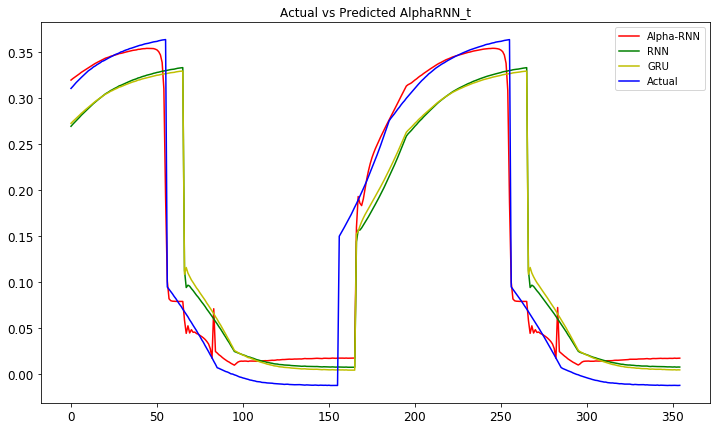

In [120]:
fig = plt.figure(figsize=(12,7))
plt.plot(rs_pred_test, color='r', label='Alpha-RNN')
plt.plot(rnn_pred_test, color='g', label='RNN')
plt.plot(gru_pred_test, color='y', label='GRU')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted AlphaRNN_t')
plt.show()

In [0]:
mse = mean_squared_error(y_test_reg[:,0],y_predicted_ar_t)
print(mse)

0.0004427545573362202


In [0]:
mse_std = np.math.sqrt(mse)
print(mse_std)

0.022216155077072364


In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_train[i]=y_predicted[i][n_steps-1][0]

In [0]:

se = mean_squared_error(y_test_reg[:,0],y_predicted_ar)
print(mse)
mse_std = np.math.sqrt(mse)
print(mse_std)

0.00042334075261903065
0.02057524611320678


#Comparison with Keras models


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=1e-3)

In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def AlphaRNN(hidden_units = 10, l1_reg=0):
  reg_model = Sequential()
  #reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model

In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_rnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]

In [0]:
rnn_model = RNN_model2(nodes_rnn,0)
rnn_fit = rnn_model.fit(x_train_reg,y_train_reg, epochs = 2000, batch_size=500, callbacks=[es])
#rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()

In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 35us/step


In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(M

In [0]:
model = KerasRegressor(build_fn=LSTM_model2, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_lstm = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
lstm_model = LSTM_model2(nodes_lstm,0)
lstm_fit = lstm_model.fit(x_train_reg,y_train_reg, epochs=2000, batch_size=500, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()




In [0]:
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()

In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

In [0]:
print("Hyper parameter tuning of GRU model")
model = KerasRegressor(build_fn=GRU_model2, epochs=2000, batch_size=500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_gru = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
gru_model = GRU_model2(nodes_gru,0)
gru_fit = gru_model.fit(x_train_reg,y_train_reg, epochs=2000, batch_size=500, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

In [0]:
# MFD: Also try GRU, SimpleRNN
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)
#gru_model = Sequential()
#gru_model.add(GRU(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
#gru_model.add(Dense(1))
#gru_model.compile(loss='mean_squared_error', optimizer='adam')

#gru_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=100, callbacks=[es])

In [0]:
#gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

374/374 [==============================] - 0s 99us/step
GRU test data mse = 0.00038023759714453945
GRU test std mse =  0.01949968197547179
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

In [0]:


hidden_size = 5
rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=100, callbacks=[es])

In [0]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
hidden_size = 5
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=500, callbacks=[es])

In [0]:
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse = " + str(np.sqrt(mse)))

374/374 [==============================] - 0s 87us/step
LSTM test data mse = 0.0005170304470553611
LSTM test std mse = 0.02273830352192883


In [0]:
lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 95us/step


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 37us/step


In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 63us/step


In [0]:
alpharnnt_pred_train = alpharnnt.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = alpharnnt.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 47us/step


In [0]:
alpharnn_pred_train = alpharnn.predict(x_train_reg, verbose=1)
alpharnn_pred_test = alpharnn.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 42us/step


In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.0004990908195479893
0.0004548309840356207
0.02234034063187017
0.021326766844405196


In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.0005000548808021149
0.00045362849019611295
0.02236190691336754
0.021298556058947118


In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.0004928369560054375
0.0004456200560310017
0.022199931441458046
0.02110971473116114


In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], alpharnnt_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], alpharnnt_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

0.0004976949721127741
0.0004485624818102432
0.02230907824435546
0.02117929370423488


In [0]:

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], alpharnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], alpharnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)


0.000511170497246813
0.00046380252857424967
0.022609079973471124
0.02153607505034865


In [0]:
# calculate mean squared error of the alpha RNN

#MSE_train = mean_squared_error(df_train[use_feature][n_steps:], y_predicted_train_t)  #train_losses[:, 0])
#print(MSE_train)
#MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_predicted_ar_t)     #validation_losses[:, 0])
#print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

NameError: ignored

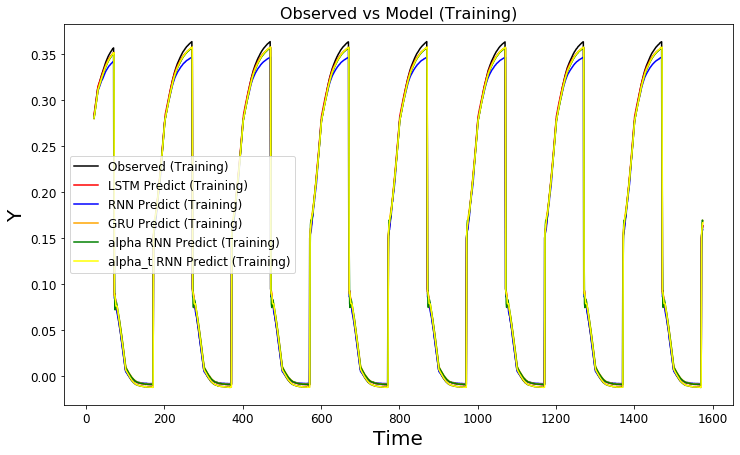

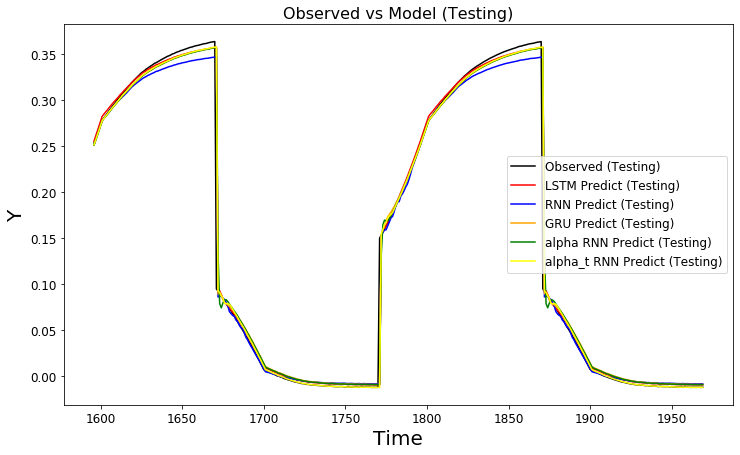

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="black", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="orange", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], alpharnn_pred_train[:,0], color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], alpharnnt_pred_train[:,0], color="yellow", label="alpha_t RNN Predict (Training)" )

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="black", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], lstm_pred_test[:, 0], color="red", label="LSTM Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="orange", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], alpharnn_pred_test,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], alpharnnt_pred_test, color="yellow", label= "alpha_t RNN Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()